## Environment Setup

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression

## Data Processing

In [2]:
# Load dataset
df = pd.read_csv('../data/SBA_cleaned_data.csv')

df_copy = df.copy()

df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891424 entries, 0 to 891423
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    891424 non-null  int64 
 1   NAICS         891424 non-null  int64 
 2   ApprovalFY    891424 non-null  int64 
 3   Term          891424 non-null  int64 
 4   NewExist      891424 non-null  int64 
 5   HasFranchise  891424 non-null  int64 
 6   UrbanRural    891424 non-null  int64 
 7   RevLineCr     891424 non-null  int64 
 8   Default       891424 non-null  int64 
 9   GrAppv        891424 non-null  int64 
 10  Industry      692257 non-null  object
dtypes: int64(10), object(1)
memory usage: 74.8+ MB


In [3]:
# Check null values in the dataset
df_copy.isnull().sum()

Unnamed: 0           0
NAICS                0
ApprovalFY           0
Term                 0
NewExist             0
HasFranchise         0
UrbanRural           0
RevLineCr            0
Default              0
GrAppv               0
Industry        199167
dtype: int64

In [4]:
# Check data types of each feature
df_copy.dtypes

Unnamed: 0       int64
NAICS            int64
ApprovalFY       int64
Term             int64
NewExist         int64
HasFranchise     int64
UrbanRural       int64
RevLineCr        int64
Default          int64
GrAppv           int64
Industry        object
dtype: object

Now that each field we care about appears to have the correct data type, we can remove the fields that won't provide much value to the analysis. These are as follows:

+ LoanNr_ChkDgt and Name - provides no value to the actual analysis

+ City and Zip - each have a large number of unique values, and my assumption is that it is not likely either would have any particularly significant values

+ Bank - Name of the bank shouldn't matter for analysis, however this could potentially be used when revisiting this analysis to determine the asset size of the bank servicing the loan

+ ChgOffDate - only applies when a loan is charged off and isn't relevant to the analysis

+ NAICS - replaced by Industry

+ NewExist - replaced by NewBusiness flag field

+ FranchiseCode - replaced by IsFranchise flag field

+ ApprovalDate and DisbursementDate - hypothesis that DaysToDisbursement will be more valueable

+ SBA_Appv - guaranteed amount is based on percentage of gross loan amount, not dollar amount typically

+ MIS_Status - Default field replaces this as the target field

In [5]:
# Verify all null values are removed from data
df_copy.isnull().sum()

Unnamed: 0           0
NAICS                0
ApprovalFY           0
Term                 0
NewExist             0
HasFranchise         0
UrbanRural           0
RevLineCr            0
Default              0
GrAppv               0
Industry        199167
dtype: int64

In [6]:
# Check the shape of the data as it stands
df_copy.shape

(891424, 11)

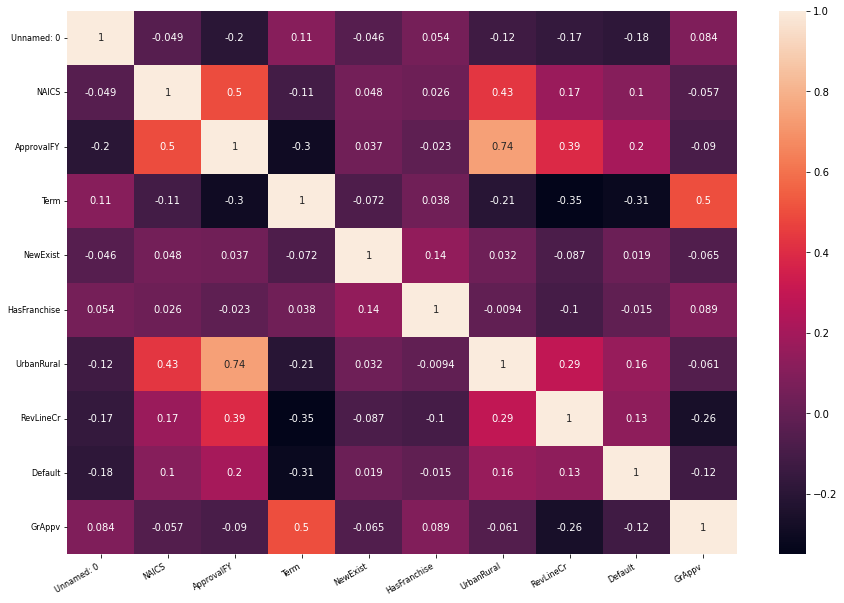

In [7]:
# Correlation Matrix
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = df_copy.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

## Build Model

In [8]:
# One-hot encode categorical data
df_copy = pd.get_dummies(df_copy)

df_copy.head()

,Unnamed: 0,NAICS,ApprovalFY,Term,NewExist,HasFranchise,UrbanRural,RevLineCr,Default,GrAppv,...,Industry_Mgmt_comp,Industry_Min/Quar/Oil_Gas_ext,Industry_Other_no_pub,Industry_Prof/Science/Tech,Industry_Public_Admin,Industry_RE/Rental/Lease,Industry_Retail_trade,Industry_Trans/Ware,Industry_Utilities,Industry_Wholesale_trade
0,0,45,1997,84,1,0,0,0,0,60000,...,0,0,0,0,0,0,1,0,0,0
1,1,72,1997,60,1,0,0,0,0,40000,...,0,0,0,0,0,0,0,0,0,0
2,2,62,1997,180,0,0,0,0,0,287000,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1997,60,0,0,0,0,0,35000,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1997,240,0,0,0,0,0,229000,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Establish target and feature fields
y = df_copy['Default']
X = df_copy.drop('Default', axis=1)

# Scale the feature values prior to modeling
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25)

In [10]:
# Initialize model
log_reg = LogisticRegression(random_state=520)

# Train the model and make predictions
log_reg.fit(X_train, y_train)
y_logpred = log_reg.predict(X_val)

# Print the results
print(classification_report(y_val, y_logpred, digits=3))

              precision    recall  f1-score   support

           0      0.853     0.976     0.910    183357
           1      0.661     0.219     0.330     39499

    accuracy                          0.842    222856
   macro avg      0.757     0.598     0.620    222856
weighted avg      0.819     0.842     0.807    222856



In [11]:
# Improve model using grid search
from sklearn.model_selection import GridSearchCV

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg_cv=GridSearchCV(log_reg,grid,cv=10)
logreg_cv.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Applications/anaconda3/lib/pytho

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.8432126575981085


In [12]:
# Improved model
log_reg2=LogisticRegression(C=10,penalty="l2", random_state=520)
log_reg2.fit(X_train,y_train)

# Print the results
print(classification_report(y_val, y_logpred, digits=3))

              precision    recall  f1-score   support

           0      0.853     0.976     0.910    183357
           1      0.661     0.219     0.330     39499

    accuracy                          0.842    222856
   macro avg      0.757     0.598     0.620    222856
weighted avg      0.819     0.842     0.807    222856



In [13]:
print("score",log_reg2.score(X_val,y_val))

score 0.8418934199662562


In [18]:
import time

start = time.process_time()
log_reg2.fit(X_train,y_train)
print("======="*12, end="\n\n\n")
end = time.process_time() - start
print("processing time = ", end, "s")



processing time =  4.156458000000043 s
